# Keller-Miksis equation simulation and plotting

In [1]:
%matplotlib notebook
import math
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import h5py

import pickle

import torch
import torch.nn as nn
import torch.jit
from torchdiffeq import odeint as odeint

from model.KellerMiksis import Keller
from model.NeuralODE import NeuralODE

#from model.DEM import DeepEuler, AdaptiveDeepEuler
from model.Euler import Euler

torch.set_default_dtype(torch.float64)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 15.0})

## Integrate the ODE

In [ ]:
begin = datetime.now()
keller = Keller()
sol = scipy.integrate.solve_ivp(keller.ode, [0, 3], [ 1.0, 0.0], rtol=1e-10, atol=1e-10)
end = datetime.now()
print(end-begin)

<IPython.core.display.Javascript object>


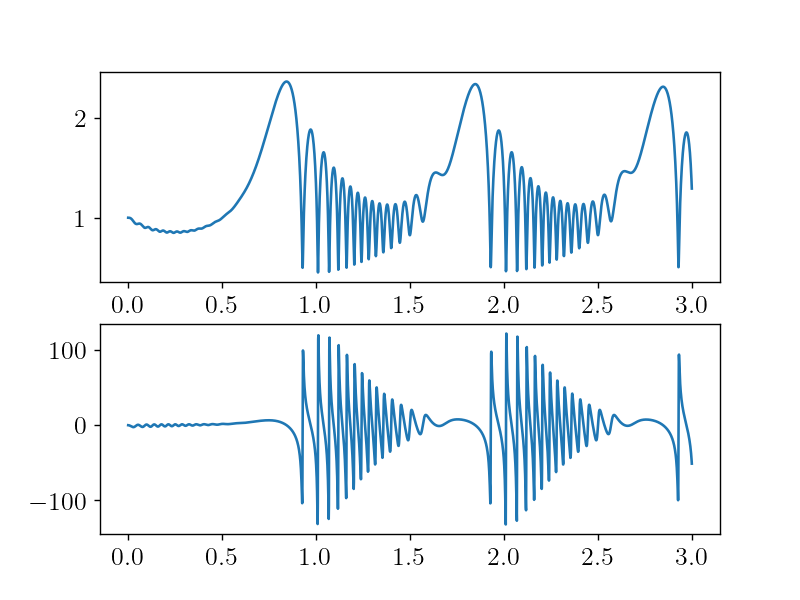

In [3]:
solut = torch.tensor(np.linspace(0, 3, 3000), dtype=torch.float64)
solu = odeint(keller, torch.tensor([[1.0, 0.0]]), solut, method="rk4",options=dict(step_size=1e-3)).detach().numpy()
fig = plt.figure(num="DopriSol")
ax = fig.add_subplot(211)
ax.plot(solut, solu[:,0,0])
ax2 = fig.add_subplot(212)
ax2.plot(solut, solu[:,0,1])
plt.show()

In [ ]:
keller = Keller()
eul_sol = scipy.integrate.solve_ivp(keller.ode, [0, 3], [ 1.0, 0.0], method=Euler, h=1e-4)

You need a trained Neural ODE to run the following section. Change the given pathes to your model and scaler. If you have no scaler, comment out the lines containing scaler and uncomment those that do not. Note that your model should be a normal pytorch model checkpoint (not a traced model).

In [ ]:
#select device
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

#initial condition
true_y0 = torch.tensor([[1., 0.]]).to(device)

NODE = NeuralODE(2,2)
loaded = torch.load("training/model_keller_i7151_2210311911.pt")
NODE.load_state_dict(loaded['model_state_dict'])
NODE.eval()

with open("training/scaler_keller_2210311911.psca.pickle", "rb") as file: 
    scaler = pickle.load(file)

t = torch.linspace(0,3,8000)
#true_y0torch = torch.tensor(true_y0)
true_y0torch = torch.tensor(scaler.transform(true_y0))
begin = datetime.now()
with torch.no_grad():
    node_sol = odeint(NODE, true_y0torch, t, atol=1e-8, rtol=1e-8)
    node_sol = scaler.inverse_transform(node_sol.detach().numpy()[:,0,:])
    #node_sol = node_sol.detach().numpy()[:,0,:]
end = datetime.now()
print(end-begin)

In [ ]:
fig = plt.figure(num="NeuralODE")
ax_traj = fig.add_subplot(211)
ax_traj.cla()
ax_traj.set_xlabel('$t$')
ax_traj.set_ylabel('$x_1$')
ax_traj.plot(sol.t, sol.y[0, :], '-', color="black", label="DOPRI")
ax_traj.plot(t.cpu().numpy(), node_sol[:, 0], '--', color="orange", label="NODE")
ax_traj.legend()
ax_traj = fig.add_subplot(212)
ax_traj.cla()
ax_traj.set_xlabel('$t$')
ax_traj.set_ylabel('$x_2$')
ax_traj.plot(sol.t, sol.y[1, :], '-', color="black", label="DOPRI")
ax_traj.plot(t.cpu().numpy(), node_sol[:, 1], '--', color="orange", label="NODE")
fig.show()
plt.savefig("Keller_NeuralODE.pdf")

In [ ]:
figur = plt.figure(num="Streamslice")
ax_vecfield = figur.add_subplot(111)
ax_vecfield.cla()
ax_vecfield.set_xlabel('$x$')
ax_vecfield.set_ylabel('$\dot x$')

x,y = np.mgrid[-5:5:21j, -5:5:21j]
dydt = NODE(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
dydt = (dydt / mag)
dydt = dydt.reshape(21, 21, 2)

ax_vecfield.streamplot(y, x, dydt[:, :, 1], dydt[:, :, 0], color="black")
ax_vecfield.set_xlim(-5, 5)
ax_vecfield.set_ylim(-5, 5)

fig.tight_layout()
fig.canvas.draw()
plt.savefig("VdP_NODE_streamslice.pdf")

## Error - Tolerance plot

In [ ]:
sol = scipy.integrate.solve_ivp(vdp, [0, 27.5], [ 1.0, 1.0], rtol=1e-10, atol=1e-10)
t = torch.linspace(0,27.5,2)
num_points = 200
min_exponent = -7
max_exponent = -2
node_errors = np.zeros(num_points)
node_tols = np.logspace( min_exponent, max_exponent, num=num_points, base=10)
i = 0;
for tol in node_tols:
    with torch.no_grad():
        pred_y = odeint(NODE, true_y0, t, atol=tol, rtol=tol ).detach().numpy()
        #print(pred_y)
        node_errors[i] = np.abs(pred_y[-1, 0, 0] - sol.y[0,-1])
        i += 1
    

In [ ]:
node_fehlberg_errors = np.zeros(num_points)
i = 0;
for tol in node_tols:
    with torch.no_grad():
        pred_y = odeint(NODE, true_y0, t, method="fehlberg2", atol=tol, rtol=tol ).detach().numpy()
        node_fehlberg_errors[i] = np.abs(pred_y[-1, 0, 0] - sol.y[0,-1])
        i += 1
    

In [ ]:
node_bosh_errors = np.zeros(num_points)
i = 0;
for tol in node_tols:
    with torch.no_grad():
        pred_y = odeint(NODE, true_y0, t, method="bosh3", atol=tol, rtol=tol ).detach().numpy()
        node_bosh_errors[i] = np.abs(pred_y[-1, 0, 0] - sol.y[0,-1])
        i += 1
    

In [ ]:
plt.figure(num="ErrorPlot")
plt.plot(node_tols, node_errors, "-", color="black", label="Dopri")
plt.plot(node_tols, node_fehlberg_errors, "-", color="orange", label="Fehlberg2")
plt.plot(node_tols, node_bosh_errors, "-", color="purple", label="Bosh3")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Tolerance")
plt.ylabel("$|x - x_{NODE}|$")
plt.legend()
plt.show()
plt.savefig("vdp_node_error_tol_comparison.pdf")